### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='BBBBBSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12471
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     27.4| 43.5914| -70.2989|       TMAX|USC00177523|    31|[00 7E 00 7E 00 7...|1997.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     2|[00 4F 00 4F 00 0...|1975.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     6|[20 50 00 00 E0 D...|1976.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     4|[90 D5 E0 D0 00 4...|1977.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     1|[00 C6 00 D3 00 D...|1978.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [17]:
print numpy.unique(df.select("station").collect())

[u'CA008201336' u'CA008206490' u'CA008206500' u'CA008206600' u'US1MAES0003'
 u'US1MAES0010' u'US1MAES0012' u'US1MEAN0021' u'US1MECM0002' u'US1MECM0003'
 u'US1MECM0007' u'US1MECM0008' u'US1MECM0013' u'US1MECM0015' u'US1MECM0018'
 u'US1MECM0020' u'US1MECM0023' u'US1MECM0027' u'US1MECM0037' u'US1MECM0054'
 u'US1MECM0055' u'US1MECM0056' u'US1MECM0060' u'US1MECM0063' u'US1MECM0086'
 u'US1MELN0001' u'US1MELN0005' u'US1MEYK0002' u'US1MEYK0020' u'US1MEYK0022'
 u'US1MEYK0025' u'US1MEYK0028' u'US1MEYK0031' u'US1MEYK0041' u'US1NHBK0001'
 u'US1NHBK0002' u'US1NHBK0007' u'US1NHBK0009' u'US1NHBK0010' u'US1NHBK0012'
 u'US1NHCR0001' u'US1NHCR0009' u'US1NHCR0026' u'US1NHCR0029' u'US1NHGR0003'
 u'US1NHHL0005' u'US1NHHL0016' u'US1NHHL0053' u'US1NHMR0004' u'US1NHMR0009'
 u'US1NHMR0015' u'US1NHMR0025' u'US1NHMR0026' u'US1NHMR0027' u'US1NHMR0033'
 u'US1NHRC0003' u'US1NHRC0007' u'US1NHRC0012' u'US1NHRC0013' u'US1NHRC0017'
 u'US1NHRC0018' u'US1NHRC0021' u'US1NHRC0024' u'US1NHST0011' u'US1NHST0013'
 u'US1NHST00

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00177523')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00177523'
1 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     27.4| 43.5914| -70.2989|       PRCP|USC00177523|    31|[00 7E 00 7E 00 7...|1997.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+



(1L, 365L)

### Script for plotting yearly plots

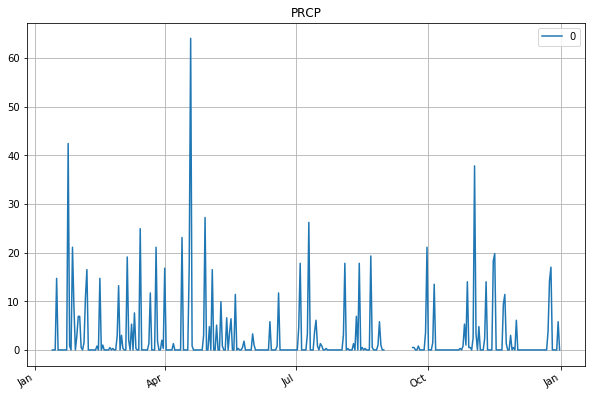

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

C:\Users\Induja\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


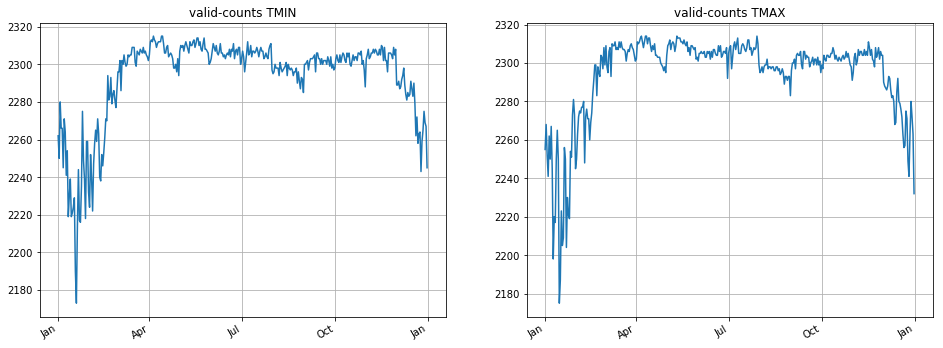

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid)

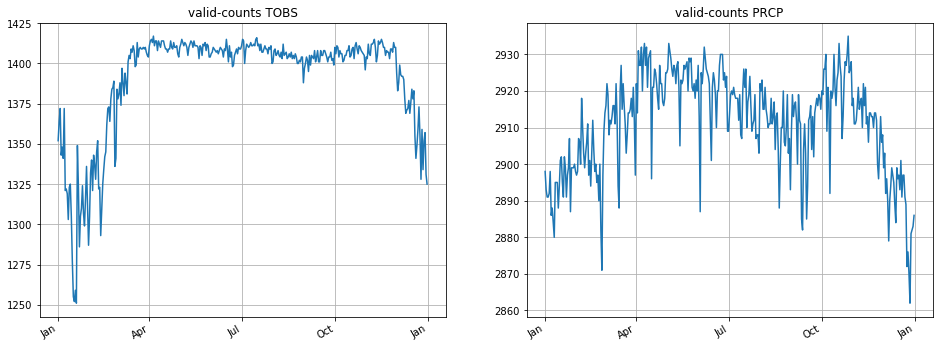

In [6]:
plot_pair(['TOBS','PRCP'],plot_valid)

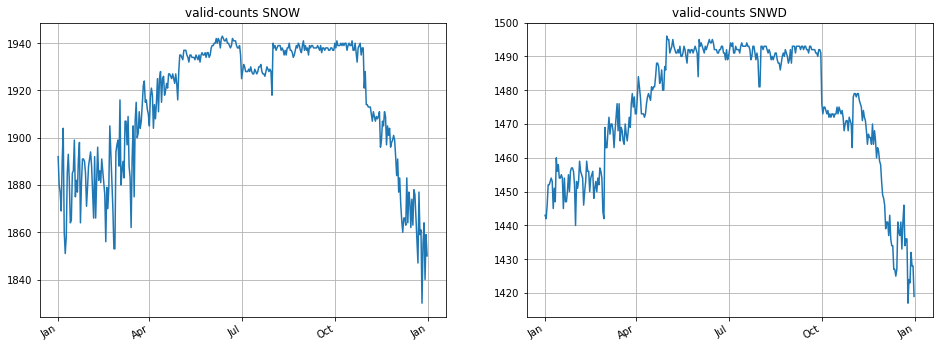

In [7]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

SELECT year,vector FROM weather
	where measurement='TMIN' 
2322 rows
+------+--------------------+
|  year|              vector|
+------+--------------------+
|1997.0|[00 7E 00 7E 00 7...|
|1975.0|[80 D8 E0 D0 B0 D...|
|1976.0|[E0 D4 10 DA 10 D...|
|1977.0|[B8 D9 08 D9 B8 D...|
|1978.0|[90 D9 90 D9 C8 D...|
|1979.0|[A0 D3 00 46 00 D...|
|1980.0|[00 D8 00 D8 A0 D...|
|1981.0|[A0 DB 78 DB 20 D...|
|1982.0|[10 DA 80 D4 70 D...|
|1983.0|[A0 D6 20 D0 80 D...|
|1984.0|[F0 DA 40 DA B0 D...|
|1985.0|[A0 D6 E0 D4 E0 D...|
|1986.0|[E0 D4 B0 D8 B0 D...|
|1987.0|[38 D9 38 D9 A0 D...|
|1988.0|[90 D9 F0 D6 98 D...|
+------+--------------------+
only showing top 15 rows



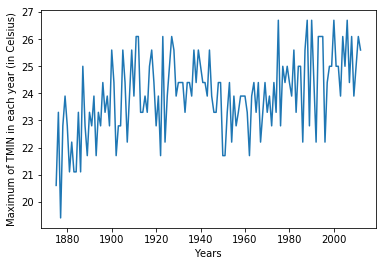

In [13]:
data={}
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT year,vector FROM weather\n\twhere measurement='%s' "%('TMIN')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(15)
#rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
rows=df1.collect()
for key, val in rows:
    if key not in data:
        data[key]=np.nanmax(unpackArray(val,np.float16))/10.0
    else:
        if np.nanmax(unpackArray(val,np.float16))/10.0>data[key]:
            data[key]=np.nanmax(unpackArray(val,np.float16))/10.0
lists = sorted(data.items()) 
x, y = zip(*lists)
plt.plot(x,y)
plt.xlabel('Years')
plt.ylabel('Maximum of TMIN in each year (in Celsius)')

In [18]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

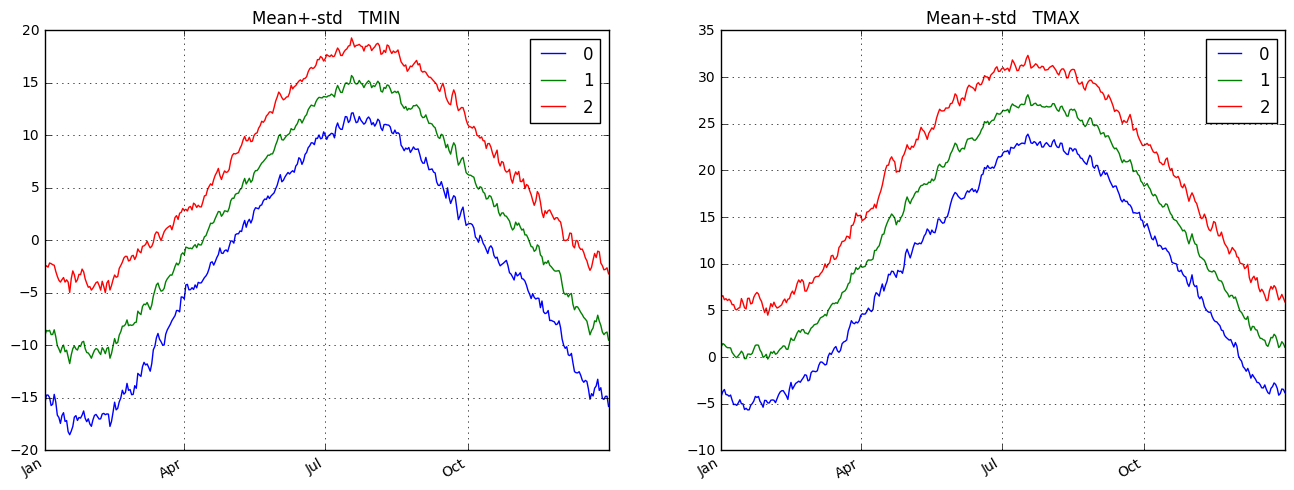

In [11]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

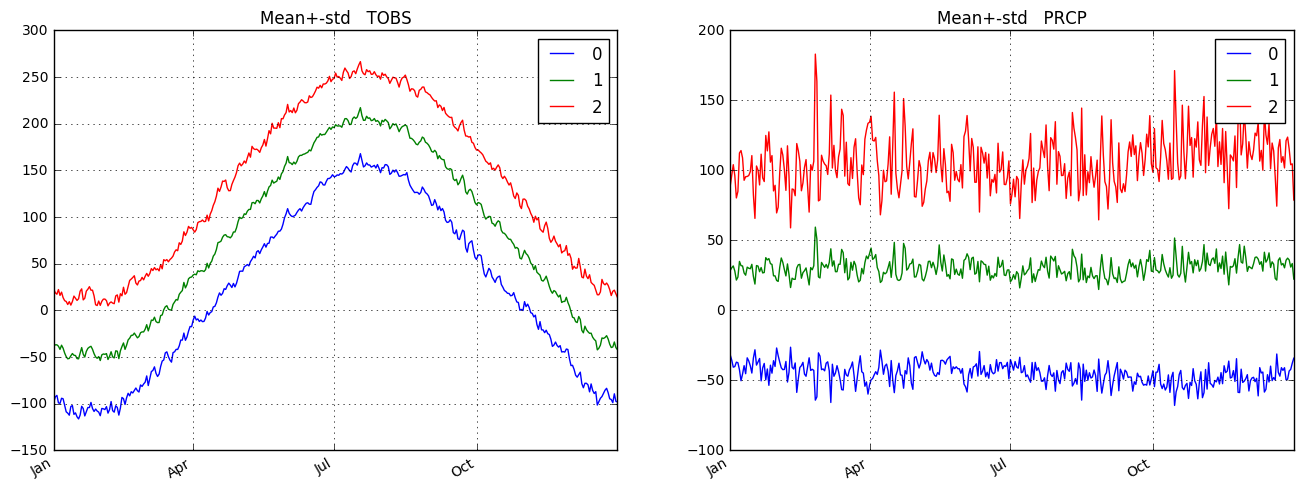

In [14]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

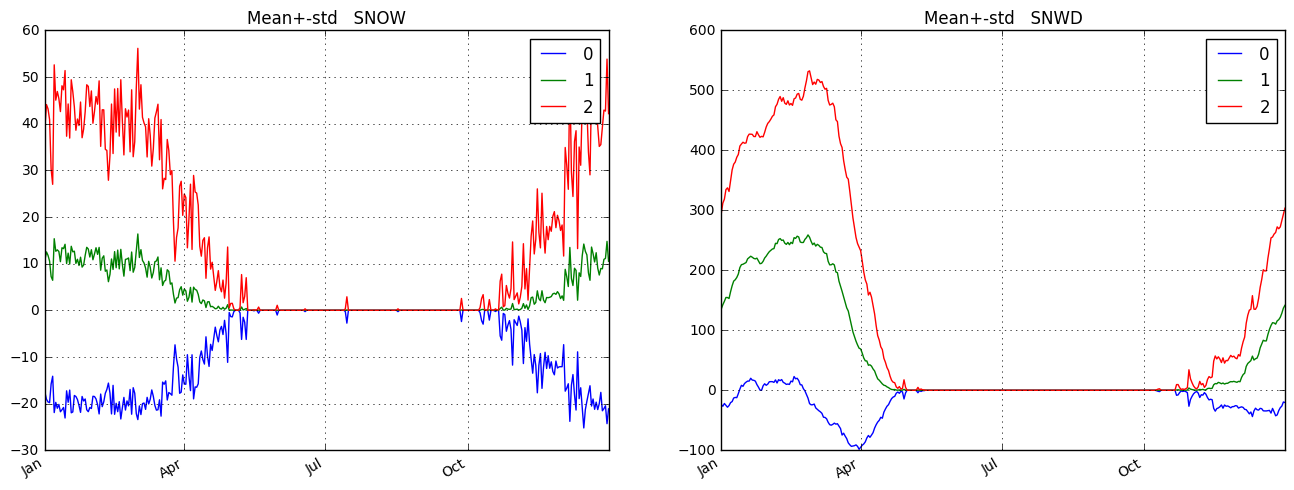

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [12]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

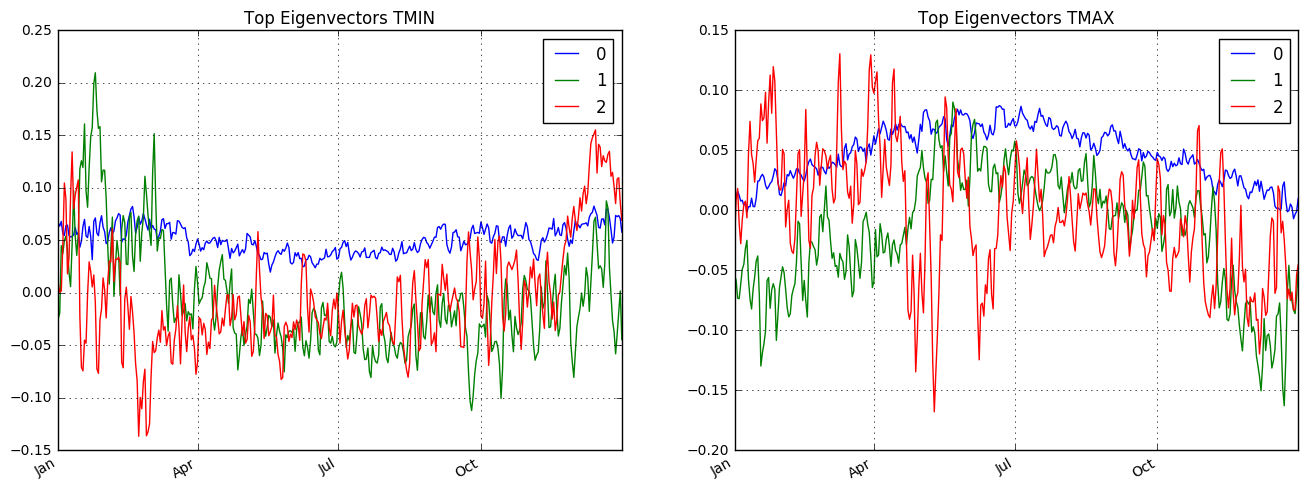

In [13]:
plot_pair(['TMIN','TMAX'],plot_eigen)

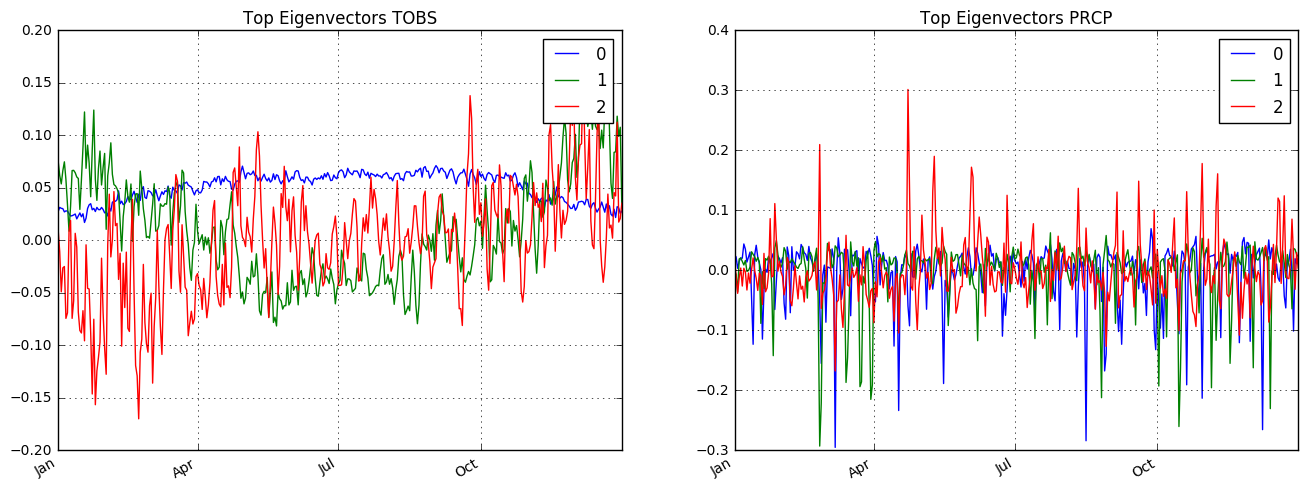

In [14]:
plot_pair(['TOBS','PRCP'],plot_eigen)

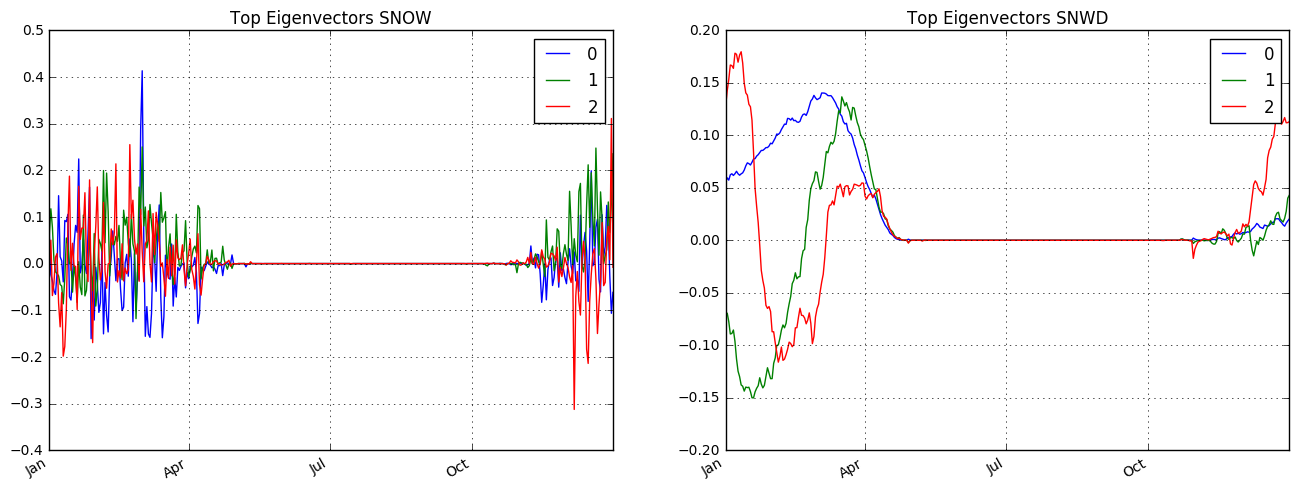

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [16]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

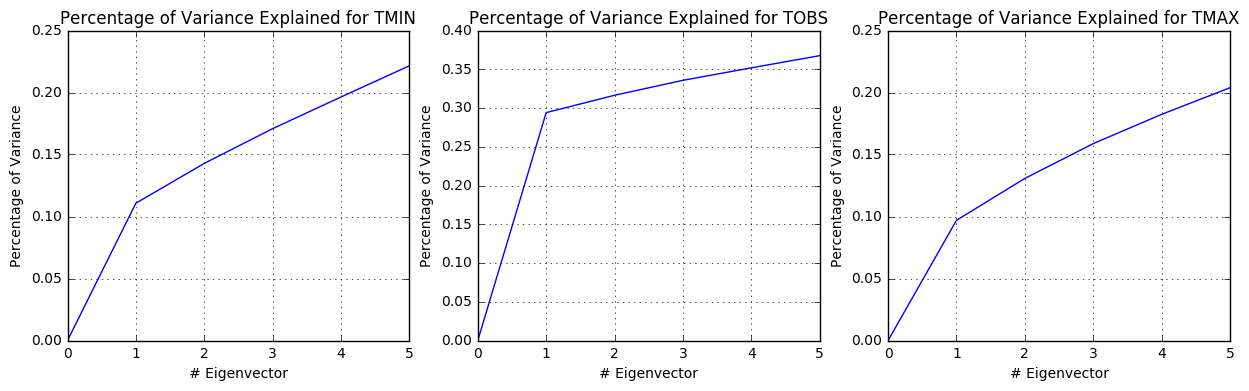

In [17]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

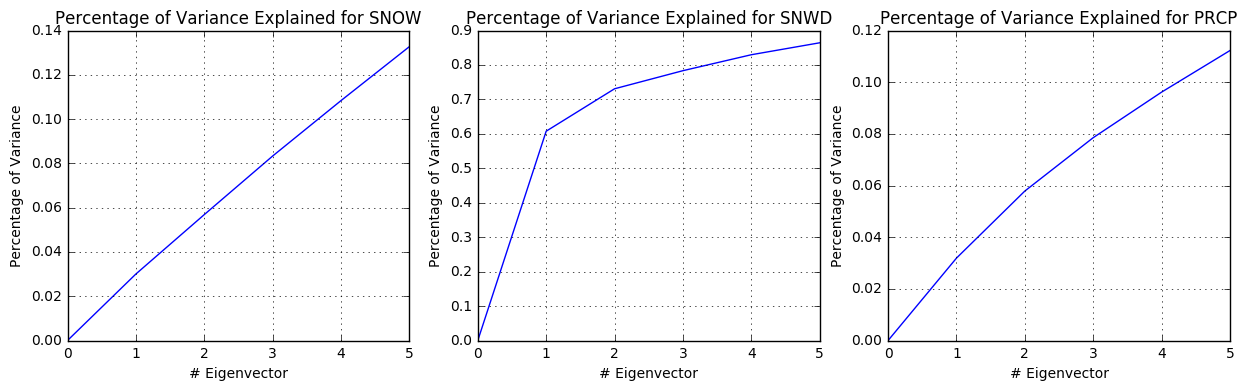

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [29]:
sc.stop()